In [11]:
%reload_ext autoreload
%autoreload 1
%aimport redditClient
%aimport RedditProcessing

In [12]:
from redditClient import redditClient
import RedditProcessing
import praw
import pandas as pd
import datetime
import json
import matplotlib.pyplot as plt
import seaborn as sns
# importing packages and nltk data libraries
import string
import codecs
import re
import sys
import nltk
from collections import Counter
nltk.download('stopwords')
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
from colorama import Fore, Back, Style
from nltk.stem import WordNetLemmatizer
import numpy as np
import math
import pyLDAvis
import pyLDAvis.lda_model
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import time
from datetime import datetime, timedelta

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zuhaf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zuhaf\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [13]:
# construct Reddit client
client = redditClient()

# sanity check, you should see your own username printed out
print(client.user.me())

Beneficial_Fox_1431


In [14]:

# Search for submissions mentioning "iphone" 
sSubredditName = 'iphone'
hotLimit = 1000
subreddit = client.subreddit(sSubredditName)

# DATA COLLECTION

In [15]:
# list to hold posts data
submission_list = []
# Creating a dictionary to store all posts data with key 'submissions'
data = {
    'submissions': []
}

# Retrieve hot posts
for submission in subreddit.hot(limit=hotLimit):
    submission_data = {
        'title': submission.title,
        'score': submission.score,
        'id': submission.id,
        'url': submission.url,
        'created': int(submission.created_utc),
        'num_comments': submission.num_comments,
        'body': submission.selftext,
        'word_count': len(submission.selftext.split()),
        'comments': []
    }

    # Retrieve comments for each post
    submission.comments.replace_more(limit=None)
    for comment in submission.comments.list():
        comment_data = {
            'id': comment.id,
            'author': str(comment.author),
            'body': comment.body,
            'created': int(comment.created_utc),
            'score': comment.score,
            'word_count': len(comment.body.split())
        }
        submission_data['comments'].append(comment_data)
    
    data['submissions'].append(submission_data)
    submission_list.append(submission_data)
    
# Save to a JSON file
with open('iphone_reddit_posts.json', 'w') as json_file:
    json.dump(data, json_file, indent=4)


# BOXPLOT

Average Word Count per Post: 70.76


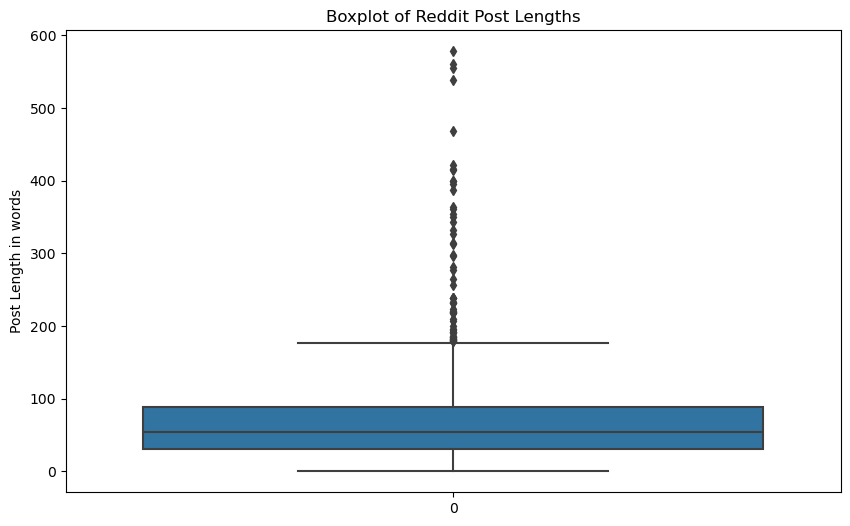

In [16]:
# boxplot to show average word count per post
posts_df = pd.DataFrame(submission_list)
# Calculate the average word count
average_word_count = posts_df['word_count'].mean()

# Printing the average word count
print(f"Average Word Count per Post: {average_word_count:.2f}")
plt.figure(figsize=(10, 6))
sns.boxplot(posts_df['word_count'])
plt.title('Boxplot of Reddit Post Lengths')
plt.ylabel('Post Length in words')
plt.show()

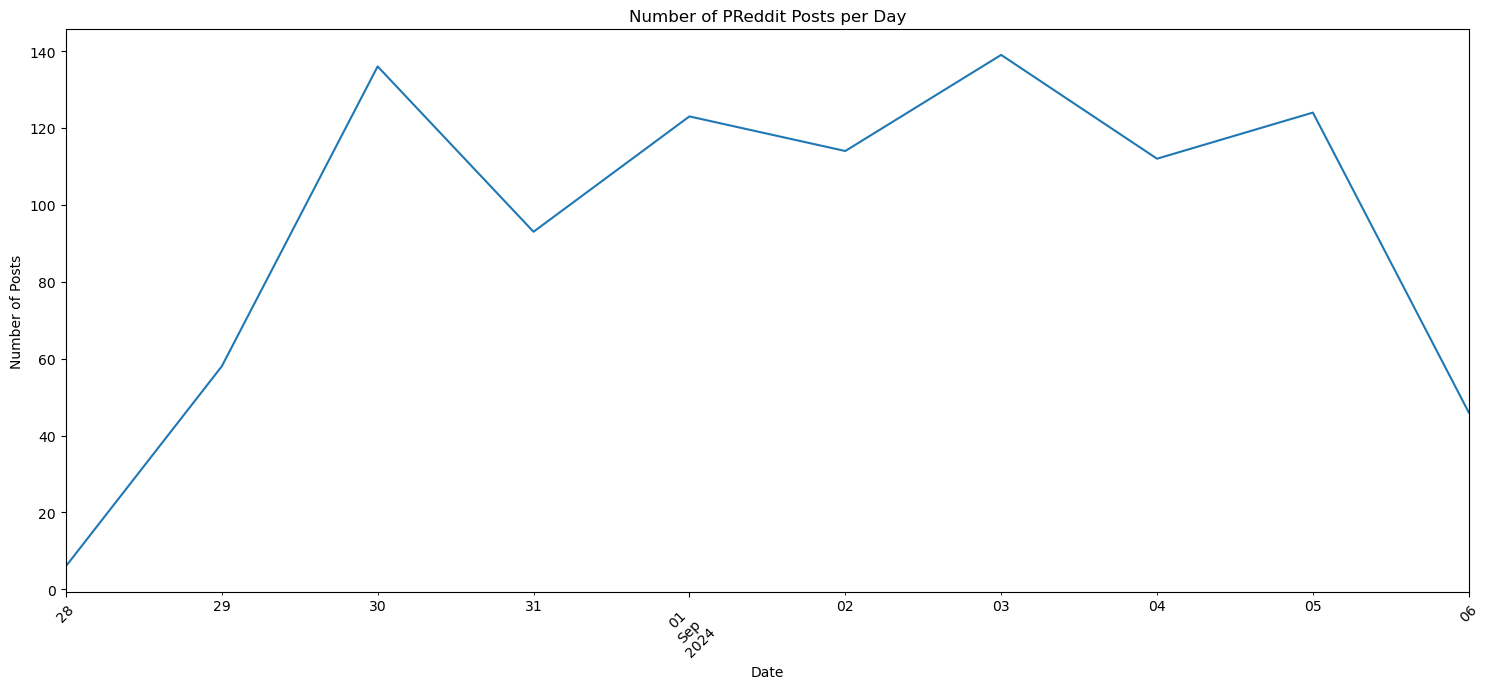

In [7]:
# Extract post dates
dates = [submission['created'] for submission in data['submissions']]

# Convert to pandas datetime
dates = pd.to_datetime(dates, unit='s')


# Create a DataFrame for the time series analysis
df = pd.DataFrame(dates, columns=['date'])

# Set the 'date' column as the index
df.set_index('date', inplace=True)

# Resample to daily intervals and count the number of posts per day
posts_per_day = df.resample('1D').size()

# Plotting the time series 
plt.figure(figsize=(15, 7))
posts_per_day.plot()
plt.title('Number of PReddit Posts per Day')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

50 Most Common Terms:
the: 16348
i: 12301
to: 10231
it: 9990
a: 9059
and: 8526
you: 5339
is: 5238
that: 4834
of: 4407
for: 4365
s: 4178
t: 3967
on: 3904
in: 3606
my: 3530
this: 3397
they: 3320
have: 3184
iphone: 3112
but: 2938
phone: 2750
with: 2673
not: 2518
if: 2442
apple: 2398
be: 2254
or: 2193
so: 2193
just: 2168
can: 1978
was: 1959
are: 1924
like: 1753
new: 1597
your: 1559
as: 1555
pro: 1542
an: 1521
from: 1521
do: 1466
when: 1435
what: 1304
m: 1289
at: 1276
there: 1234
me: 1224
more: 1216
year: 1200
don: 1197


C:\Users\zuhaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zuhaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zuhaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\zuhaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

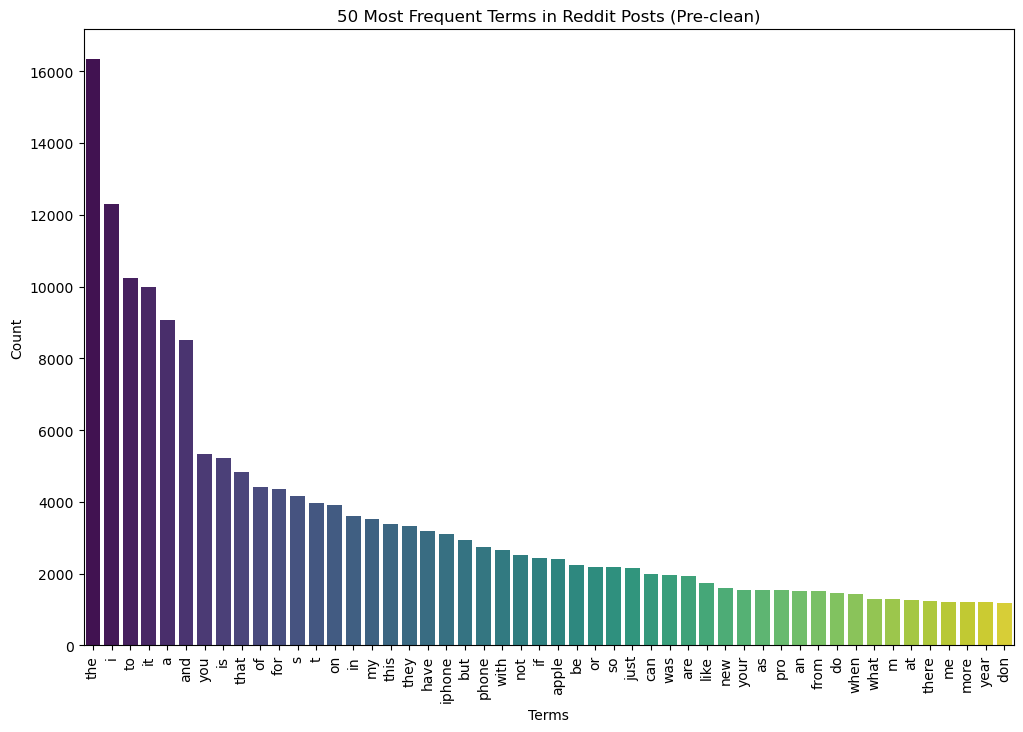

In [17]:
# Load the JSON file
with open('iphone_reddit_posts.json', 'r') as f:
    data = json.load(f)

# Extract submission and comment bodies
submission_bodies = [submission['body'] for submission in data['submissions']]
comment_bodies = []
for submission in data['submissions']:
    comment_bodies.extend([comment['body'] for comment in submission['comments']])

# Combine submission and comment bodies
all_text = submission_bodies + comment_bodies

# Tokenize text: split by whitespace and remove empty strings
tokens = []
for text in all_text:
    tokens.extend(re.findall(r'\b\w+\b', text.lower()))  

# Count word frequencies
word_counts = Counter(tokens)

# Get the 50 most common terms
most_common_terms = word_counts.most_common(50)

# Print the results
print("50 Most Common Terms:")
for term, count in most_common_terms:
    print(f"{term}: {count}")

# Plotting the 50 most common terms
terms, counts = zip(*most_common_terms)  # Unpack the terms and counts

plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.barplot(x=list(terms), y=list(counts), palette="viridis")
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.xlabel("Terms")
plt.ylabel("Count")
plt.title("50 Most Frequent Terms in Reddit Posts (Pre-clean)")
plt.show()


# PRE-PROCESSING

In [18]:
# Pre-Processing
# Initialize components
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = stopwords.words('english') + lPunct + ['via', '...', '…', '"', "'", '`','⣿',' ','']
lemmatizer = WordNetLemmatizer()

# Create a RedditProcessing instance
redditProcessor = RedditProcessing.RedditProcessing(tweetTokenizer, lStopwords, lemmatizer)

# Load the JSON file containing submissions and comments
with open('iphone_reddit_posts.json', 'r') as f:
    data = json.load(f)

# Process submission bodies
submission_bodies = [submission['body'] for submission in data['submissions']]
processed_submission_bodies = [redditProcessor.process(body) for body in submission_bodies]

# Process comment bodies
comment_bodies = []
for submission in data['submissions']:
    comment_bodies.extend([comment['body'] for comment in submission['comments']])
processed_comment_bodies = [redditProcessor.process(body) for body in comment_bodies]

# Combine processed results
processed_texts = {
    'submission_bodies': processed_submission_bodies,
    'comment_bodies': processed_comment_bodies
}

# Print out results
print("Processed Submission Bodies:")
for tokens in processed_texts['submission_bodies']:
    print(tokens)

print("\nProcessed Comment Bodies:")
for tokens in processed_texts['comment_bodies']:
    print(tokens)

Processed Submission Bodies:
['welcome', 'weekly', 'stickied', 'wsib', 'thread', 'question', 'buying', 'selling', 'trading', 'giveaway', 'ask', 'away', 'please', 'remember', 'adhere', 'rule', 'found', 'sidebar', 'usual', 'serious', 'issue', 'subreddit', 'please', 'contact', 'moderator', 'directly', 'thread', 'also', 'question', 'preorders', 'shipment', 'device', 'note', 'comment', 'sorted', 'new', 'convenience', 'archive', 'previous', 'buy', 'thread', 'best', 'viewed', 'browser', 'mobile', 'type', 'searchbar', 'title', 'buy', 'author', 'automoderator', 'without', 'bracket', 'including', 'quotation', 'mark', 'around', 'title', 'author']
['general', 'advice', 'concerned', 'battery', 'support', 'faq', 'wiki', 'battery', 'health', 'battery', 'health', 'depends', 'usage', 'variety', 'factor', 'normal', 'see', 'decrease', 'battery', 'health', '7-10', 'per', 'year', 'resulting', 'battery', 'health', '80-85', 'year', 'number', 'fluctuate', 'remain', 'decrease', 'quickly', 'small', 'period', 'c

Top 50 Most Common Terms:
phone: 3291
iphone: 2880
apple: 2170
year: 2056
like: 1761
new: 1588
pro: 1538
one: 1291
get: 1271
time: 1098
would: 1083
every: 968
issue: 918
make: 913
use: 873
people: 861
case: 857
still: 810
even: 804
upgrade: 798
screen: 757
think: 750
also: 748
need: 735
thing: 734
good: 714
work: 714
camera: 712
support: 707
know: 694
back: 683
want: 667
really: 653
release: 651
see: 648
photo: 642
much: 628
app: 620
io: 611
max: 605
better: 584
message: 583
way: 571
battery: 564
could: 549
product: 541
update: 522
something: 521
got: 519
device: 509


C:\Users\zuhaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zuhaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\zuhaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
C:\Users\zuhaf\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.ap

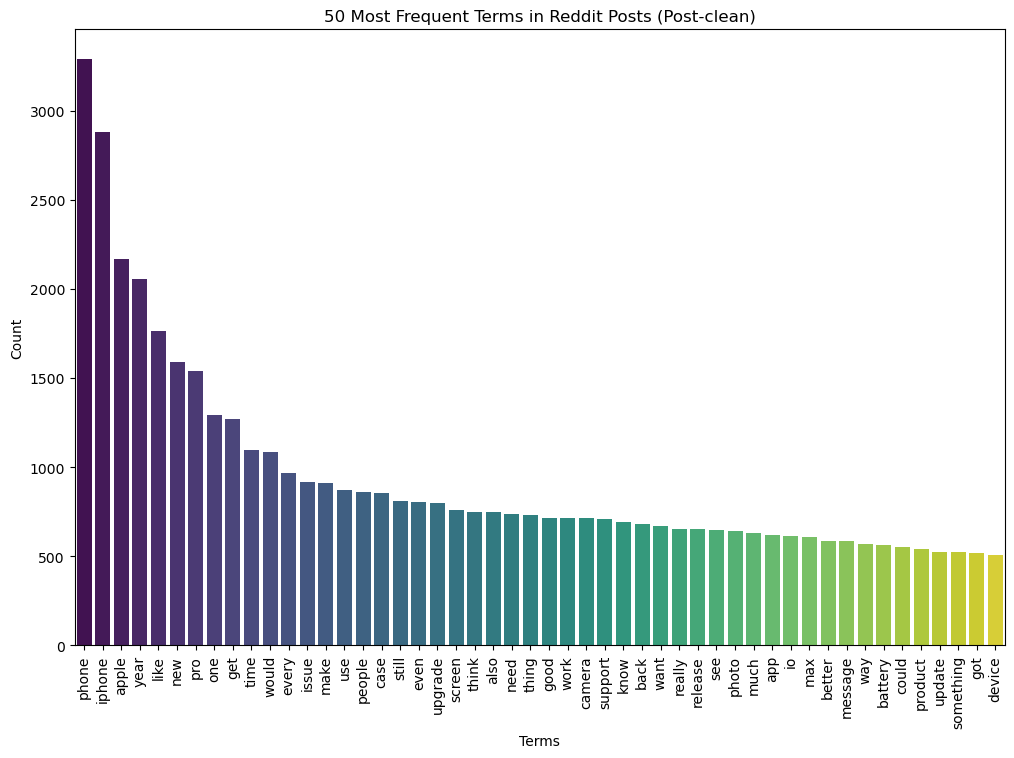

In [19]:
# Initialize a counter to track the frequency of all tokens
termFreqCounter = Counter()

# Combine all tokens from both submission bodies and comment bodies
for tokens in processed_texts['submission_bodies']:
    termFreqCounter.update(tokens)

for tokens in processed_texts['comment_bodies']:
    termFreqCounter.update(tokens)

# Get the 50 most common terms
most_common_terms = termFreqCounter.most_common(50)

# Print out the most common terms and their frequencies
print("Top 50 Most Common Terms:")
for term, count in most_common_terms:
    print(f"{term}: {count}")

# Plot the most common terms
terms, counts = zip(*most_common_terms)

plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.barplot(x=list(terms), y=list(counts), palette="viridis")
plt.xticks(rotation=90)  # Rotate x labels for better readability
plt.xlabel("Terms")
plt.ylabel("Count")
plt.title("50 Most Frequent Terms in Reddit Posts (Post-clean)")
plt.show()

In [20]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    """
    Compute the overall sentiment of the list of tokens in lTokens, using the countWordSentimentAnalysis approach.
    
    @param lTokens: List of tokens to calculate the overall sentiment for.
    @param setPosWords: Set of positive words.
    @param setNegWords: Set of negative words.
    
    @returns Sentiment score for lTokens.
    """
    
   
    posNum = len([tok for tok in lTokens if tok in setPosWords])

    
    negNum = len([tok for tok in lTokens if tok in setNegWords])

   
    sentiment = posNum - negNum
                

    return sentiment


In [21]:
def printColouredTokens(lTokens, setPosWords, setNegWords, sentiment):
    """
    Print out the tokens in different colours, according to sentiment.
    If positive, in red.
    If negative, in blue.
    Otherwise no colouring.
    
    @param lTokens: List of tokens to print and colour.
    @param setPosWords: Set of positive words.
    @param setNegWords: Set of negative words.
    @param sentiment: Sentiment score of list of tokens.
    """
        
    for token in lTokens:
        if token in setPosWords:
            print(Fore.RED + token + ', ', end='')
        elif token in setNegWords:
            print(Fore.BLUE + token + ', ', end='')
        else:
            print(Style.RESET_ALL + token + ', ', end='')

    print(': {}'.format(sentiment))
    

In [22]:
def countWordSentimentAnalysis(setPosWords, setNegWords, sTweetsFilename, bPrint, redditProcessor):
    """
    Basic sentiment analysis.  Count the number of positive words, count the negative words, overall polarity is the
    difference in the two numbers.

    @param setPosWords: set of positive sentiment words
    @param setNegWords: set of negative sentiment words
    @param sFilename: name of input file containing a json formated dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param redditProcessor: RedditProcessing object, used to pre-process each tweet.

    @returns: list of reddit posts, in the format of [date, sentiment]
    """


    lSentiment = []
    # open file and process reddit submissions and comments, one by one
    with open(sTweetsFilename, 'r') as f:
        redditDump = json.load(f)
        
        for submission in redditDump['submissions']:
            postText = submission['title']
            postDate = submission['created']
            
            # pre-process the reddit post text
            lTokens = redditProcessor.process(postText)
            
            # compute sentiment
            sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
                
            # save the date and sentiment of each reddit post (used for time series)
            lSentiment.append([pd.to_datetime(postDate, unit='s'), sentiment])

            # if we are printing, each token is printed and coloured according to red if positive word, and blue
            # if negative
            if bPrint:
                printColouredTokens(lTokens, setPosWords, setNegWords, sentiment)
                
            # process the comments
            for comment in submission['comments']:
                postText = comment['body']
                postDate = comment['created']
                
                # pre-process the tweet text
                lTokens = redditProcessor.process(postText)
            
                # compute sentiment
                sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
                
                # save the date and sentiment of each tweet (used for time series)
                # lSentiment.append([pd.to_datetime(postDate,unit='s'), sentiment])
                lSentiment.append([pd.to_datetime(postDate, unit='s'), sentiment])

                # if we are printing, each token is printed and coloured according to if the are positive or negative 
                # sentiment
                if bPrint:
                    printColouredTokens(lTokens, setPosWords, setNegWords, sentiment)


    return lSentiment


In [23]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.
    
    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [24]:
def vaderSentimentAnalysis(sTweetsFilename, bPrint, tweetProcessor):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param sTweetsFilename: name of input file containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    # open file and process tweets, one by one
    with open(sTweetsFilename, 'r') as f:
        redditDump = json.load(f)
        
        for submission in redditDump['submissions']:
            postText = submission['title']
            postDate = submission['created']
            
            # pre-process the post text
            lTokens = redditProcessor.process(postText)

            # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
            # see workshop sheet for what dSentimentScores holds
            dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

            # save the date and sentiment of each post (used for time series)
            lSentiment.append([pd.to_datetime(postDate, unit='s'), dSentimentScores['compound']])

            # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
            # of positive and negative words, we cannot use colorama to label each token
            if bPrint:
                vaderPrintTokens(lTokens, dSentimentScores)
                
                
            # process the comments
            for comment in submission['comments']:
                postText = comment['body']
                postDate = comment['created']
                
                # pre-process the post text
                lTokens = redditProcessor.process(postText)

                # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
                # see workshop sheet for what dSentimentScores holds
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

                # save the date and sentiment of each post (used for time series)
                lSentiment.append([pd.to_datetime(postDate, unit='s'), dSentimentScores['compound']])

                # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
                # of positive and negative words, we cannot use colorama to label each token
                if bPrint:
                    # print(postText)
                    vaderPrintTokens(lTokens, dSentimentScores)
                    
                    
    return lSentiment

In [25]:
# input file of set of postive words
posWordFile = 'positive-words.txt'
# input file of set of negative words
negWordFile = 'negative-words.txt'
# input file of set of reddit posts (json format)
redditFile = 'iphone_reddit_posts.json'
# flag to determine whether to print out tweets and their sentiment
flagPrint = True
# specify the approach to take, one of [count, vader]
# change this to use a different sentiment approach
approach = 'vader'

In [26]:
# construct the reddit pro-processing object
# use tweet tokenizer
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
lStopwords = stopwords.words('english') + lPunct + ['via', '...', '…', '"', "'", '`','⣿',' ','']
lemmatizer = WordNetLemmatizer()

# Create a RedditProcessing instance
redditProcessor = RedditProcessing.RedditProcessing(tweetTokenizer, lStopwords, lemmatizer)


# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

In [27]:
# compute the sentiment
# to change method, update parameter settings, particularly the variable 'approach' and rerun the parameter setting cell,
# and also this cell
lSentiment = []
if approach == 'count':
    lSentiment = countWordSentimentAnalysis(setPosWords, setNegWords, redditFile, flagPrint, redditProcessor)
elif approach == 'vader':
    lSentiment = vaderSentimentAnalysis(redditFile, flagPrint, redditProcessor)

weekly, buy, order, shipping, thread
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
since, iphone, stopped, working, looking, new, one, considering, iphone, big, difference, price, difference, little, also, think, new, camera, layout
neg: 0.095, neu: 0.905, pos: 0.0, compound: -0.2263, 
planning, uprading, samsung, galaxy, s21, week, iphone, looking, either, pro, know, pretty, similar, term, except, maybe, 120hz, display, pro, nice, guy, think, better, option, cluntry, price, right, though, cheaper, pro, decent, yeah, thought, much, appreciated
neg: 0.0, neu: 0.676, pos: 0.324, compound: 0.9246, 
iphone, pro, max, going, upgrade, phone, get, pro, max, price, issue, advice, welcomed
neg: 0.0, neu: 0.833, pos: 0.167, compound: 0.34, 
iphone, pro, max, wondering, worth, upgrading, new, pro, max, waiting, longer, new, come, enough, new, feature, warrant, upgrade, like, fact, new, phone, usb, 48mp, camera, upgrade, worth, waiting, year, two, better, feature, could, work, would, worth, wait
n

                     date  sentiment
0     2024-10-07 10:30:13     0.0000
1     2024-10-08 17:16:57    -0.2263
2     2024-10-09 04:37:14     0.9246
3     2024-10-09 17:48:54     0.3400
4     2024-10-09 17:58:57     0.8442
...                   ...        ...
13068 2024-10-06 16:45:20     0.0000
13069 2024-10-06 16:32:46     0.9300
13070 2024-10-06 16:46:43     0.0000
13071 2024-10-06 17:54:40     0.0000
13072 2024-10-06 12:45:59     0.0000

[13073 rows x 2 columns]


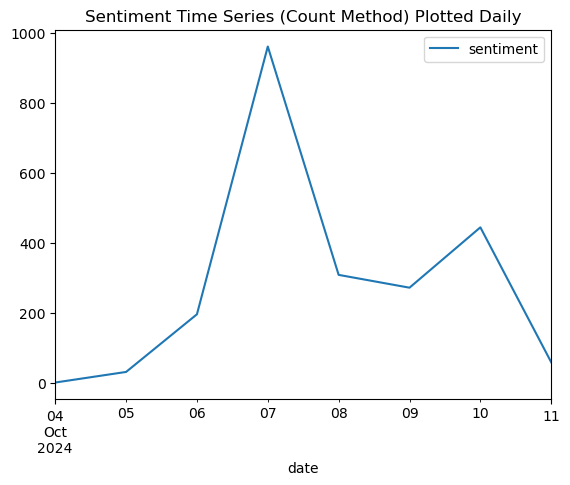

In [28]:
# we are using pandas for this, but first we need to get it into a pandas data frame structure
series = pd.DataFrame(lSentiment, columns=['date', 'sentiment'])
print(series)

# tell pandas that the date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)

# pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
# column to floats
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)

# This step is not necessary, but pandas has a neat function that allows us to group the series at different
# resolution. The 'how=' part tells it how to group the instances. In this example, it says we want to group
# by hour, and add up all the sentiment scores for the same hour and create a new time series called 'newSeries'
# with this hour resolution
# TODO: play with this for different resolution, '1H' is by hour, '1M' is by minute etc
newSeries = series.resample('1D').sum()

# this plots and shows the time series
newSeries.plot()

# Add a title to the plot
plt.title('Sentiment Time Series (Count Method) Plotted Daily')

# Display the plot
plt.show()


### LDA MODEL

In [20]:
# number of topics to discover (default = 10)
topicNum = 10
# maximum number of words to display per topic (default = 10)
# Answer to Exercise 1 (change from 10 to 15)
wordNumToDisplay = 15
# this is the number of features/words to used to describe our documents
# please feel free to change to see effect
featureNum = 1500

In [21]:
# Convert tokens back to strings
processed_submission_bodies_str = [' '.join(tokens) for tokens in processed_texts['submission_bodies']]
processed_comment_bodies_str = [' '.join(tokens) for tokens in processed_texts['comment_bodies']]

# Combine submission and comment texts into a single list
processed_texts_combined = processed_submission_bodies_str + processed_comment_bodies_str

# using this combined list for the CountVectorizer
custom_stop_words = ['iphone', 'phone']
tfVectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=featureNum, stop_words=custom_stop_words + stopwords.words('english'))
tf = tfVectorizer.fit_transform(processed_texts_combined)

# Extract the names of the features (in this case, the words)
tfFeatureNames = tfVectorizer.get_feature_names_out()


In [22]:

#
# LDA MODEL

ldaModel = LatentDirichletAllocation(n_components =topicNum, max_iter=10, learning_method='online').fit(tf)

### Visualizing Topics

In [23]:
def display_topics(model, featureNames, numTopWords):
    """
    Prints out the most associated words for each feature.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    @param numTopWords: number of words to print per topic.
    """

    # print out the topic distributions
    for topicId, lTopicDist in enumerate(model.components_):
        print("Topic %d:" % (topicId))
        print(" ".join([featureNames[i] for i in lTopicDist.argsort()[:-numTopWords - 1:-1]]))

In [24]:
display_topics(ldaModel, tfFeatureNames, wordNumToDisplay)

Topic 0:
battery issue update device life backup display get fine charge need might mode touch hour
Topic 1:
upgrade people see mini like want get every new even year getting sim keep give
Topic 2:
screen number back black tell white watch game try maybe face free without apple camera
Topic 3:
would apple button use make apps could setting app find one work also location know
Topic 4:
io like yes problem even android work tried lol great know thing version side sound
Topic 5:
pro max case plus screen protector model yeah 3gs size would feel glass scratch bumper
Topic 6:
year one apple get new still better got probably like really use much since good
Topic 7:
app photo pop store icloud data video thanks way storage download notification know delete say
Topic 8:
look first like time one got screen thank case ever every back best really almost
Topic 9:
support issue question contact message please help google apple looking action may automatically removed subreddit


In [25]:
panel = pyLDAvis.lda_model.prepare(ldaModel, tf, tfVectorizer, mds='tsne')
pyLDAvis.display(panel)

### WordCloud

In [26]:
def displayWordcloud(model, featureNames):
    """
    Displays the word cloud of the topic distributions, stored in model.

    @param model: lda model.
    @param featureNames: list of strings, representing the list of features/words.
    """

    # this normalises each row/topic to sum to one
    # use this normalisedComponents to display your wordclouds
    normalisedComponents = model.components_ / model.components_.sum(axis=1)[:, np.newaxis]
    
    topicNum = len(model.components_)
    # number of wordclouds for each row
    plotColNum = 3
    # number of wordclouds for each column
    plotRowNum = int(math.ceil(topicNum / plotColNum))

    for topicId, lTopicDist in enumerate(normalisedComponents):
        lWordProb = {featureNames[i] : wordProb for i,wordProb in enumerate(lTopicDist)}
        wordcloud = WordCloud(background_color='black')
        wordcloud.fit_words(frequencies=lWordProb)
        plt.subplot(plotRowNum, plotColNum, topicId+1)
        plt.title('Topic %d:' % (topicId+1))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

    plt.show(block=True)

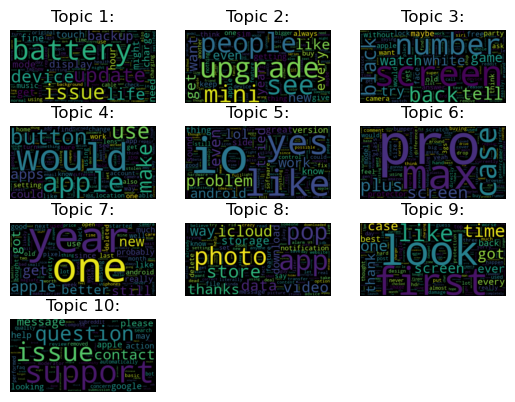

In [27]:
# display wordcloud
displayWordcloud(ldaModel, tfFeatureNames)